# Hybrid vortex sheet-point vortex model

This notebook implements the hybrid vortex sheet-point vortex model of Darakananda and Eldredge (JFM 2019)
and demonstrates it on several problems. The model allows a variety of vortex models (vortex sheet models, vortex element models, and variable-strength low-order vortex models), based on some tunable parameters.

A few notes:
- this implements the model for a flat plate only
- it is set up in a reference frame in which the plate is in motion and quiescent flow at infinity. The plate is moving from left to right, so it is backwards from the typical perspective.

There are pre-set kinematics below that can be chosen below.

In [1]:
using PotentialFlow

In [2]:
using Plots
using ProgressMeter # Not really necessary, but can be helpful in slower vortex sheet cases
using SpecialFunctions
using PotentialFlow.UnPack

## Define some functions that will be used

#### Time Marching
This carries out the calculation of velocity for every element in the problem, including
vortex elements and the plate itself

In [3]:
function compute_ẋ!(ẋ, x, t)
   plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

In [8]:
counter_min(Tmin,Δt) = isinf(Tmin) ? Inf : round(Int,Tmin/Δt)

counter_min (generic function with 1 method)

#### Set up the Theodorsen solution for comparison purposes, where appropriate

In [7]:
C(κ::Float64) = hankelh2(1,κ)/(hankelh2(1,κ)+im*hankelh2(0,κ))

struct Theodorsen
    kin :: RigidBodyMotions.PitchHeave
    L   :: Float64
end

function (theo::Theodorsen)(t::Float64)
    @unpack L, kin = theo
    @unpack Y,Ẏ,U₀,α,a,α̇,Ÿ,α̈,K = kin
    # defined for motion in +x direction
    ReΓb = π*L*(-Ẏ(t) + U₀*α(t) + (1/4 + a)*L*α̇(t))
    ImΓb = π*L*(-2K*Y(t) - U₀*α̇(t)/(2K) + (1/4 + a)*L*2K*α(t))
    fy = π*(L/2)^2*(-Ÿ(t) + a*α̈(t) + U₀*α̇(t)) + U₀*real((ReΓb+im*ImΓb)*C(K))
    momp = π*(L/2)^2*(a*Ÿ(t)-(L^2/32+a^2)*α̈(t)-(L/4+a)*U₀*α̇(t)) + (L/4-a)*U₀*real((ReΓb+im*ImΓb)*C(K))
    return fy, momp+a*fy
end

## Now set up the problem kinematics
Choose one of the pre-set options to start

In [31]:
L = 1.0   # chord length

probtype = :pitchheave
#probtype = :fixedangle
#probtype = :pitchup


phproblem = :yuanhang
#phproblem = :kdharvest
#phproblem = :kdpropulsion

if probtype == :pitchheave
    
    if phproblem == :yuanhang
        # Yuanhang UVa case
        f_Hz = 2.4 # frequency in Hz
        U_ms = 0.125 # free stream in m/s
        c_m = 0.08 # chord length in m
        a = 0.5 #0.25 # location of pitch axis, a = 0.5 is leading edge
        ϕ = 0.0  # phase lag of pitch to heave
        A = 0.0 #0.0  # heave amplitude/chord
        fstar = f_Hz*c_m/U_ms # fc/U
        α₀ = 0π/180 # mean angle of attack
        Δα = 5π/180 #2π/180 # amplitude of pitching
    elseif phproblem == :kdharvest
        # Kinsey-Dumas case - energy harvesting case
        a = 0.25 #0.2 # location of pitch axis, a = 0.5 is leading edge
        ϕ = -π/2  # phase lag of pitch to heave
        A = 1.0 #1.0  # heave amplitude/chord
        fstar = 0.14 # fc/U
        α₀ = 0π/180 # mean angle of attack
        Δα = 60π/180 #20π/180 # amplitude of pitching
    elseif phproblem == :kdpropulsion       
        # Kinsey-Dumas case - propulsion case
        a = 0.25 #0.2 # location of pitch axis, a = 0.5 is leading edge
        ϕ = -π/2  # phase lag of pitch to heave
        A = 1.0 #1.0  # heave amplitude/chord
        fstar = 0.14 # fc/U
        α₀ = 0π/180 # mean angle of attack
        Δα = 20π/180 #20π/180 # amplitude of pitching
    end
    
    χ = Δα/atan(2π*A*fstar) # Feathering parameter
    K = π*fstar # reduced frequency, K = πfc/U
    Tchar = 1.0/fstar # characteristic time scale
    
    U₀ = 1.0
    oscil = RigidBodyMotions.PitchHeave(U₀,a,K,ϕ,α₀,Δα,A);
    motion = Plates.RigidBodyMotion(oscil);
    α₀ = motion.kin.α(0.0)
    
    println("f* = ",fstar)
    println("Δα = ",Δα*180/π)
    println("α(1/4) = ",abs(atan(2*K*A)-Δα)*180/π)
    println("A/c = ",A)
    println("K = ",K)
    println("χ = ",χ)
    println("Char. time = ",Tchar)

    
elseif probtype == :pitchup
    
    K = 0.7
    Δα = π/2
    Tchar = 1.0/K # Characteristic time scale

    pitchup = let U₀ = 1,    # Translation velocity
              a  = 0.5,  # Pitching axis (leading edge)
              K = 0.7,   # Pitch rate
              α₀ = 0.0,  # Nominal starting angle
              t₀ = 0.3,  # Nominal starting time
              Δα = π/2,  # Total angle change
              ramp = Plates.RigidBodyMotions.EldredgeRamp(11) # Smooth ramp function
    
                Plates.RigidBodyMotions.Pitchup(U₀, a, K, α₀, t₀, Δα, ramp)
              end;
    motion = Plates.RigidBodyMotion(pitchup);
    α₀ = motion.kin.α(0.0);

    println("Char. time = ",Tchar)
    
elseif probtype == :fixedangle

    α₀ = 45π/180 #ramp(0)
    U₀ = 1.0
    Tchar = 1.0; # Just a default value, not physically meaningful here
    motion = Plates.RigidBodyMotion(U₀ + 0im, 0.0);
end

f* = 1.536
Δα = 5.0
α(1/4) = 5.0
A/c = 0.0
K = 4.825486315913922
χ = Inf
Char. time = 0.6510416666666666


#### Plot the effective angle of attack, just for checking

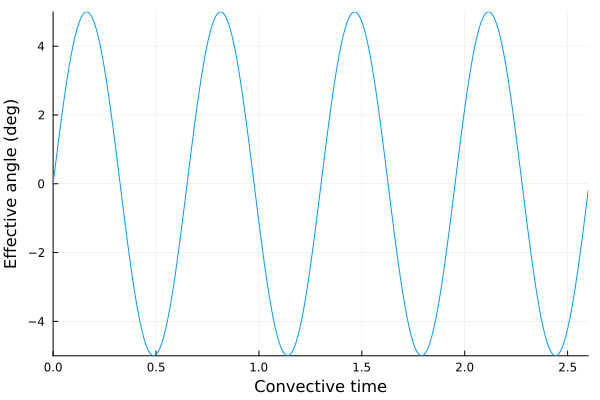

In [32]:
if (probtype != :fixedangle)
    t = 0:0.01:(4.0./fstar)
    Vy = map(x -> imag(x[1]),motion.kin.(t))
    αeff = 0*atan.(-Vy)+motion.kin.α.(t)
    plot(t,αeff*180/π,xlim=(0,Inf),ylim=(-Inf,Inf),legend=false,ylabel="Effective angle (deg)",xlabel="Convective time")
end

## Select the metaparameters for the hybrid vortex model
Read these notes first

* $N$ is the number of plate control points

* $\Delta t$ is the time step size.

* $\delta$ is the blob radius. It is best to set this to around 0.05 times the chord length.

* `lesp` and `tesp` are the critical edge suction parameters at the leading and trailing edge, respectively
    - Setting this to 0 leads to the Kutta condition at that edge
    -  Setting this to a large positive value ($\sim 10$) suppresses vortex shedding from that edge

* $B_f$ sets the tolerance for force error in the hybrid model.
    - Setting this to zero turns off variable-strength point vortices and generates a traditional vortex sheet model. 
    - It is generally advisable to set this to around 0.05 or 0.4

* $T^*_{min}$ sets the minimum time interval between the release of a new active vortex from the tip of each vortex sheet.
    - Setting this to infinity (and setting $B_f$ to 0) generates a pure vortex sheet model.
    - Setting this to 0 generates a discrete vortex model
    - For a hybrid model, it is generally best to set this between 0.1 and 0.3
    
* $t_f$ is the final time    

In [33]:
# Usually not much need to change the next three parameters
N = 128 
Δt = 1e-2
δ = 0.05  #0.1 #0.01

# For the pitch-up case, set lesp to around 1 to 1.75
# For the fixed angle case, set lesp to 0 to 0.5
# For the pitch-heave case at low amplitude, set lesp to 10 to suppress LE shedding
lesp = 10.0 #10.0
tesp = 0.0


# For the pitch-up case, set Bf to around 0.2 and Tmin to [0.2,0.2] or greater
# For the fixed angle case, any value is okay
# For the Yuanhang case, Bf should be 0.4 or so and Tmin = [0.05,0.05] to get an efficient vortex model
# For both Kinsey-Dumas cases, Bf should be 0.1 and Tmin = [0.1,0.1]
Bf = 0.4 #0.1
Tmin = [0.1,0.1]/2; #[0.1,0.1]; #2e-1;


tf = 6*Tchar;

### Run it!

In [34]:
plate = Plate(N, L, 0, α₀)

Plates.enforce_no_flow_through!(plate, motion, (), 0.0)

sys = (plate, ((), ()))

# sys[1] is the plate, sys[2] is the vortex system
# sys[2][i] corresponds to edge i (i = 1 is leading edge, i = 2 is trailing edge)
# sys[2][i][1] is the set of blobs associated with edge i
# sys[2][i][1][1] is the current active vortex for edge i
# sys[2][i][2] is the vortex sheet associated with edge i. Its first entry will be turned into a blob.

sys = PotentialFlow.shed_new_vorticity!(sys, motion, δ, 0.0, lesp, tesp)

states = Tuple[];
forces = [];
moments = [];

T = Δt:Δt:tf

# Set up Theodorsen solution results
if probtype == :pitchheave
    theo = Theodorsen(oscil,L)
    fytheo = map(x -> x[1], theo.(Δt:Δt:tf))
    momtheo = map(x -> x[2], theo.(Δt:Δt:tf))
end

counter = [0, 0]

countermin = counter_min.(Tmin,Δt)
ϵf = Bf*Δt 

@showprogress for t in T
    push!(states, deepcopy(sys))
   
    ẋs = (motion, allocate_velocity(sys[2]))

    compute_ẋ!(ẋs, sys, t)
    
    lesys, tesys = sys[2]
    push!(forces, Plates.force(plate, motion, sys[2], ẋs[2], (newest_element(lesys...)..., newest_element(tesys...)...), Δt))   
    push!(moments, Plates.moment(plate, motion, sys[2], ẋs[2], (newest_element(lesys...)..., newest_element(tesys...)...), Δt))   

    advect!(sys, sys, ẋs, Δt)
    
    for i in 1:2  # each edge
        
        # If this edge's vortex system is not set up, then skip the transfer
        length(sys[2][i]) == 2 || continue
        
        edge_blobs, edge_sheet = sys[2][i]
        
        # Calculate the impulse matching corrections to the active vortex position
        Δzs = [impulse_matching_correction(sblob, edge_blobs[1], plate) for sblob in edge_sheet.blobs]    
      
        # Circulation is only transferred from the sheet to the active blob if
        # - the sheet is long enough, and
        # - more than one sheet segment can be transferred without surpassing the error tolerance
        new_blob = transfer_circulation!(edge_sheet, edge_blobs[1], Δzs, plate, ϵf)

        # If the active blob has been modified, then set the counter to zero. Otherwise, increment
        # the counter.
        if new_blob == edge_blobs[1]
            counter[i] += 1
        else
            counter[i] = 0
            edge_blobs[1] = new_blob
        end
        
        # if we have waited long enough between active blob releases, and the sheet is sufficiently long,
        # then convert current active vortex into an inactive one, and release tip of sheet as new active vortex
        if length(edge_sheet) > 2 && counter[i] >= countermin[i]
            sheettip_to_blob!(edge_blobs,edge_sheet)
            counter[i] = 0
        end
    end
    
    # Fix up the vortex sheet with filtering or remeshing
    for i in 1:2
        length(sys[2][i]) == 2 || continue
        edge_blobs, edge_sheet = sys[2][i]
        
        # Filter
        Sheets.arclength(edge_sheet) ≥ 50Δt && Sheets.filter!(edge_sheet, 2Δt, 8Δt)
        
        # or remesh
        #Sheets.arclength(edge_sheet) ≥ 30Δt && Sheets.remesh!(edge_sheet,2Δt)
    end
      
    Plates.enforce_no_flow_through!(plate, motion, sys[2], t)
    sys = shed_new_vorticity!(sys, motion, δ, t, lesp, tesp)
    

end

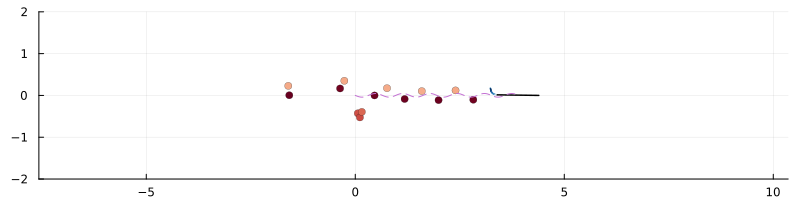

In [35]:
plt = plot(states[end],color = cgrad(:RdBu,rev=true), ratio=1,legend=:none,markersize=4,markerstrokealpha=1,
            markerstrokewidth=0.5,linewidth=1.5,framestyle=false,
            ylim=(-2,2),size=(800,200))

# Plot the trajectory
zc = map(x -> x[1].c,states[1:end]) 
plot!(real.(zc),imag.(zc),linestyle=:dash)
plt

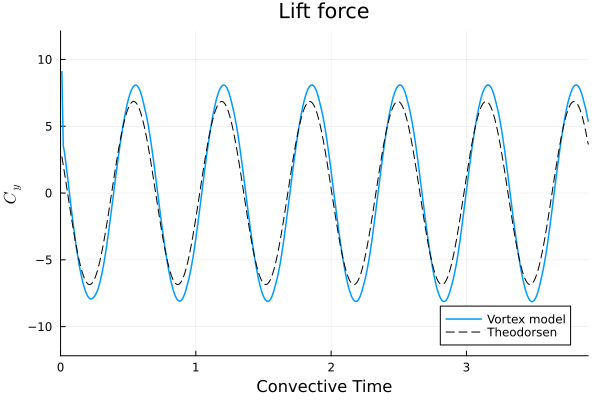

In [36]:
plt = plot(ylabel = "\$C_y\$", xlim = (0,Inf), ylim = (min(1.5*minimum(2imag.(forces[2:end])),0),max(1.5*maximum(2imag.(forces[2:end])),0)), 
    xlabel = "Convective Time",title="Lift force")
plot!(Δt:Δt:tf, 2imag.(forces), linewidth = 1.5, linestyle = :solid, label = "Vortex model")
if (probtype == :pitchheave)
    plot!(Δt:Δt:tf, 2fytheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")
end
plt

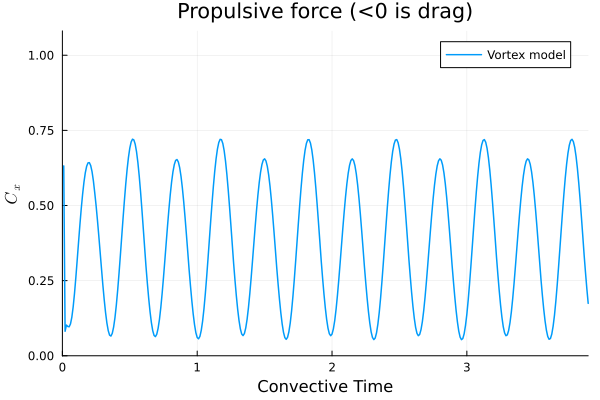

In [37]:
plt = plot(ylabel = "\$C_x\$", xlim = (0,Inf), ylim = (min(1.5*minimum(2real.(forces[2:end])),0),max(1.5*maximum(2real.(forces[2:end])),0)), 
    xlabel = "Convective Time",title="Propulsive force (<0 is drag)")
plot!(Δt:Δt:tf, 2real.(forces), linewidth = 1.5, linestyle = :solid, label = "Vortex model")
plt

In [38]:
if probtype == :pitchup
    plot(motion.kin.α.(Δt:Δt:tf)*180/π, 2imag.(forces), linewidth = 1.5, linestyle = :solid, xlabel="Angle (deg)",ylabel = "\$C_y\$",label = "Vortex model")
end

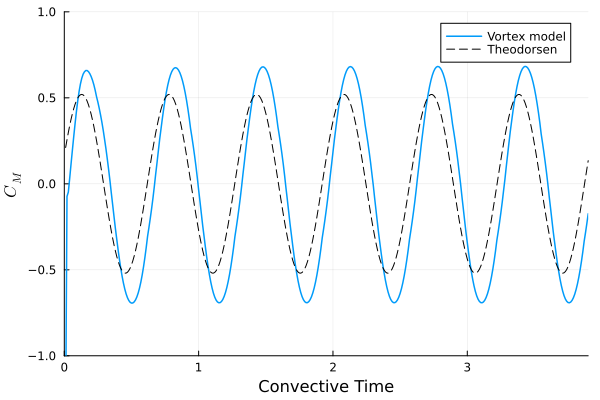

In [39]:
plt = plot(ylabel = "\$C_M\$", xlim = (0,Inf), ylim = (-1,1), 
    xlabel = "Convective Time")
plot!(plt,Δt:Δt:tf, 2moments, linewidth = 1.5, linestyle = :solid, label = "Vortex model")
if (probtype == :pitchheave)
    plot!(plt,Δt:Δt:tf, 2momtheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")
end

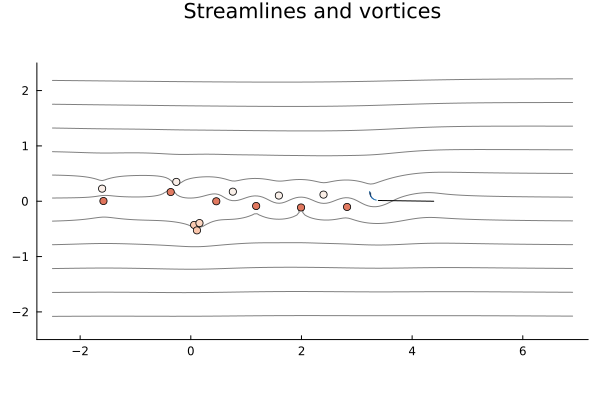

In [47]:
x = -2.5:0.05:U₀*tf+3
y = -2.5:0.05:2.5

# Generate streamlines in a frame translating with the plate (i.e. windtunnel frame)
plate, ambient_sys = states[end]
fs = Freestreams.Freestream(-U₀)

Plates.enforce_no_flow_through!(plate, motion, (ambient_sys,fs), tf)

streamlines(x,y,(plate,ambient_sys,fs),ratio=1,ylim=(minimum(y),maximum(y)),legend=false,title="Streamlines and vortices")
plot!(states[end],color = cgrad(:RdBu,rev=true))
#plot!(size=(400,400))

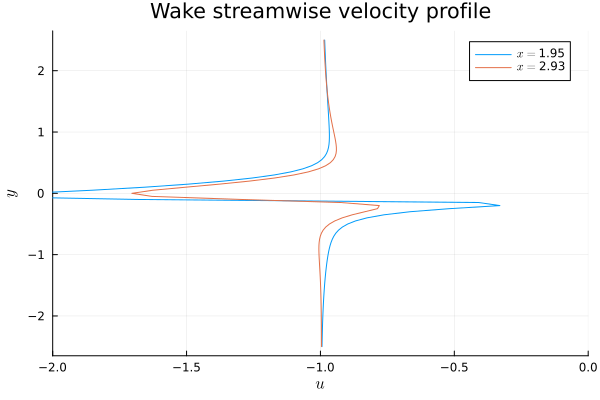

In [48]:
xwake1 = 0.5*tf;
xwake2 = 0.75*tf;
w1 = induce_velocity(xwake1 .+ im*y,(plate,ambient_sys,fs),tf);
w2 = induce_velocity(xwake2 .+ im*y,(plate,ambient_sys,fs),tf);

plot(title="Wake streamwise velocity profile",ylabel="\$y\$",xlabel="\$u\$",xlim=(-2,0))
plot!(real(w1),y,label="\$x = \$"*string(round(xwake1,digits=2)))
plot!(real(w2),y,label="\$x = \$"*string(round(xwake2,digits=2)))